# Z-Stack Compiler

This notebook transforms raw ONI microscopy TIF files into Z-stacks and multi-channel Maximum Intensity Projections (MIPs).

### Goals:
1. Group files by XY position and Z-index.
2. Compile Z-stacks per raw image.
3. Compute multi-channel MIPs and save full Z-stacks.

In [11]:
import os
import re
from collections import defaultdict
import numpy as np
import tifffile
from pathlib import Path
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt

# Default rendering settings
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 10)

## 1. Parameters

Define the input directory and output paths.
- `input_dir`: Path to raw ONI TIFs.
- `output_dir_mips`: Path to save MIPs.
- `output_dir_stacks`: Path to save full Z-stacks.

In [12]:
input_dir = "/Volumes/guttman/primarydata/imaging/20251223-ONI-gmgao-ViewRNAXistInExTsix-WT_dTsixdSPEN_dSPENDox24h/dSPENDox24h/"
output_dir_mips = os.path.join(input_dir, "results/01_MIPs")
output_dir_stacks = os.path.join(input_dir, "results/01_stacks")

# Channel configuration: "image_idx:side:channel_name, ..." (1-indexed images)
# Standard ONI setup: Image 1 has 647 (right) and 488 (left), Image 2 has 561 (left), Image 3 has 405 (left)
# Order below follows wavelength (High to Low)
channel_config_str = "1:right:647_Xist_intron1, 2:left:561_Tsix, 1:left:488_Xist_exon, 3:left:405_DAPI"

os.makedirs(output_dir_mips, exist_ok=True)
os.makedirs(output_dir_stacks, exist_ok=True)

## 2. Helper Functions

The following functions handle file parsing, Z-stack assembly, and MIP generation.

In [ ]:
def parse_oni_filename(filename: str) -> Dict:
    """Extract metadata from ONI filenames (e.g., prefix-X-123.4Y567.8Z-0.500-Z1.tif)"""
    # Robust regex to handle variable separators and optional Z-position
    # Handles: prefix-X2065..., prefix-X-119...
    pattern = r"(?P<prefix>.*)-X(?P<x>[\d\.-]+)Y(?P<y>[\d\.-]+)(?:Z(?P<z_pos>[\d\.-]+))?-Z(?P<z_index>\d+)"
    match = re.search(pattern, filename)
    if not match: return None
    return match.groupdict()

def group_files_by_position(directory: str) -> Dict[str, List[Tuple[int, str]]]:
    """Group files by position key and sort by Z-index."""
    groups = defaultdict(list)
    for filename in os.listdir(directory):
        if not filename.endswith(".tif"): continue
        parsed = parse_oni_filename(filename)
        if not parsed: continue

        pos_key = f"{parsed['prefix']}_X{parsed['x']}_Y{parsed['y']}"
        groups[pos_key].append((int(parsed['z_index']), os.path.join(directory, filename)))

    for key in groups:
        groups[key].sort(key=lambda x: x[0])
    return dict(groups)

def parse_channel_config(config_str: str) -> List[Tuple[int, str, str]]:
    """
    Returns: List of (image_index, camera_side, channel_name) tuples (0-indexed)
    """
    channels = []
    for entry in config_str.split(','):
        parts = [p.strip() for p in entry.split(':')]
        if len(parts) != 3: continue
        channels.append((int(parts[0])-1, parts[1].lower(), parts[2]))
    return channels

def to_pascal_case(text: str) -> str:
    segments = re.split(r'[_\-\s]+', text)
    return "".join(s[:1].upper() + s[1:] for s in segments if s)

def split_image(image: np.ndarray, side: str) -> np.ndarray:
    width = image.shape[-1]
    half = width // 2
    return image[..., :half] if side == 'left' else image[..., half:]

def build_zstack(file_list: List[Tuple[int, str]], image_idx: int) -> np.ndarray:
    slices = []
    for _, path in file_list:
        img = tifffile.imread(path)
        if img.ndim == 2: img = img[np.newaxis, ...]
        slices.append(img[image_idx])
    return np.stack(slices, axis=0)

## 3. Run Pipeline

Process all XY positions and save multi-channel MIPs and Stacks.

In [ ]:
position_groups = group_files_by_position(input_dir)
channels = parse_channel_config(channel_config_str)

print(f"Found {len(position_groups)} positions.")
print(f"Saving MIPs to: {output_dir_mips}")
print(f"Saving Stacks to: {output_dir_stacks}")

for pos_key, file_list in position_groups.items():
    print(f"Processing {pos_key}...")

    # Cache z-stacks for each unique raw image index to avoid redundant loading
    unique_img_indices = set(ch[0] for ch in channels)
    zstack_cache = {idx: build_zstack(file_list, idx) for idx in unique_img_indices}

    mips = []
    full_stacks = [] # List to hold (Z, H, W) arrays for each channel
    ch_names = []

    for img_idx, side, name in channels:
        zstack = zstack_cache[img_idx]

        # Split camera side -> Shape: (Z, H, W)
        zstack_split = np.stack([split_image(s, side) for s in zstack], axis=0)

        # Compute MIP -> Shape: (H, W)
        mip = np.max(zstack_split, axis=0)
        mips.append(mip)

        # Store Full Stack -> Shape: (Z, H, W)
        full_stacks.append(zstack_split)

        ch_names.append(to_pascal_case(name))

    ch_order_str = "_".join(ch_names)

    # --- Save MIP ---
    # Shape: (C, H, W)
    combined_mip = np.stack(mips, axis=0)
    output_path_mip = os.path.join(output_dir_mips, f"{pos_key}_MIP_ChOrder_{ch_order_str}.tif")
    tifffile.imwrite(output_path_mip, combined_mip, imagej=True, metadata={'axes': 'CYX'})

    # --- Save Full Stack ---
    # Shape: (C, Z, H, W) -> Transpose to (Z, C, H, W) to match TZCYXS constraint
    combined_stack = np.stack(full_stacks, axis=0)
    combined_stack = np.transpose(combined_stack, (1, 0, 2, 3))
    output_path_stack = os.path.join(output_dir_stacks, f"{pos_key}_Stack_ChOrder_{ch_order_str}.tif")
    # axes 'ZCYX' matches order (indices 1, 2, 3, 4) in TZCYXS
    tifffile.imwrite(output_path_stack, combined_stack, imagej=True, metadata={'axes': 'ZCYX'})

    print(f"  Saved: {output_path_stack}")


Found 24 positions.
Saving MIPs to: /Volumes/guttman/primarydata/imaging/20251223-ONI-gmgao-ViewRNAXistInExTsix-WT_dTsixdSPEN_dSPENDox24h/dSPENDox24h/results/01_MIPs
Saving Stacks to: /Volumes/guttman/primarydata/imaging/20251223-ONI-gmgao-ViewRNAXistInExTsix-WT_dTsixdSPEN_dSPENDox24h/dSPENDox24h/results/01_stacks
Processing dSPENDox24h_X-1068.286767_Y3133.626949...
  Saved: /Volumes/guttman/primarydata/imaging/20251223-ONI-gmgao-ViewRNAXistInExTsix-WT_dTsixdSPEN_dSPENDox24h/dSPENDox24h/results/01_stacks/dSPENDox24h_X-1068.286767_Y3133.626949_Stack_ChOrder_647XistIntron1_561Tsix_488XistExon_405DAPI.tif
Processing dSPENDox24h_X-119.507129_Y2913.610743...
  Saved: /Volumes/guttman/primarydata/imaging/20251223-ONI-gmgao-ViewRNAXistInExTsix-WT_dTsixdSPEN_dSPENDox24h/dSPENDox24h/results/01_stacks/dSPENDox24h_X-119.507129_Y2913.610743_Stack_ChOrder_647XistIntron1_561Tsix_488XistExon_405DAPI.tif
Processing dSPENDox24h_X-1490.967101_Y3133.624358...
  Saved: /Volumes/guttman/primarydata/imaging

## 4. Visualization

Display the last processed MIP for verification.

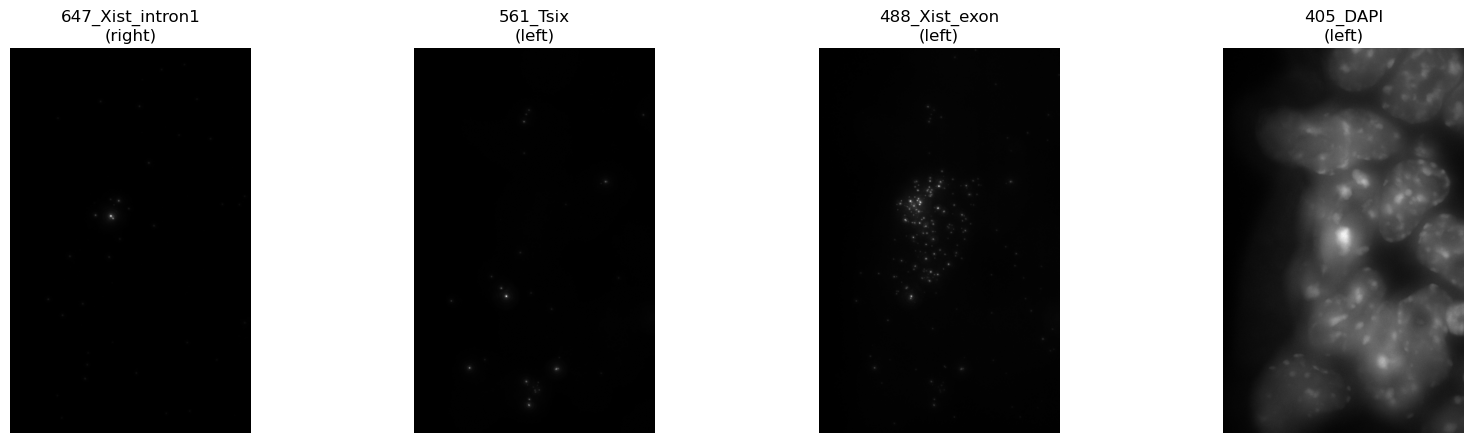

In [15]:
if 'combined_mip' in locals():
    fig, axes = plt.subplots(1, len(channels), figsize=(20, 5))
    for i, (img_idx, side, name) in enumerate(channels):
        axes[i].imshow(combined_mip[i], cmap='gray')
        axes[i].set_title(f"{name}\n({side})")
        axes[i].axis('off')
    plt.show()